# Character Segmentation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

# Import Widgets
import ipywidgets as widgets
from IPython.display import display, clear_output

# Import costume functions, corresponding to notebooks
from detect import page, words

print("OpenCV: " + cv2.__version__)
print("Numpy: " + np.__version__)
print("TensorFlow: " + tf.__version__)

OpenCV: 3.1.0-dev
Numpy: 1.12.0
TensorFlow: 1.0.0-rc1


In [2]:
def implt(img, cmp=None, t=''):
    """ Show image using plt """
    plt.imshow(img, cmap=cmp)
    plt.title(t)
    plt.show()
    
    
def resize(img, height, allways=False):
    """ Resize image to given height """
    if (img.shape[0] > height or allways):
        rat = height / img.shape[0]
        return cv2.resize(img, (int(rat * img.shape[1]), height))
    
    return img

## Load Image and Separate Words

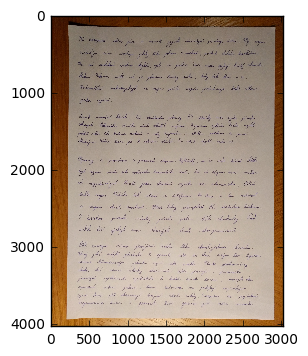

In [3]:
IMG = "text"

image = cv2.cvtColor(cv2.imread("data/pagedet/%s.jpg" % IMG), cv2.COLOR_BGR2RGB)
implt(image)

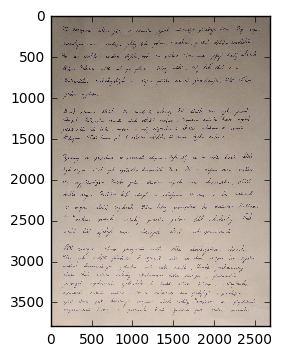

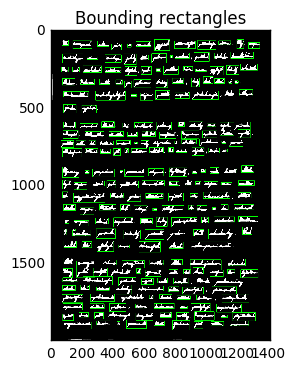

In [4]:
crop = page.detection(image)
implt(crop)
bBoxes = words.detection(crop)

## Load Model

In [5]:
# Run this only once or it will fail
sess = tf.InteractiveSession()

images = np.genfromtxt('data/gapdet/data.csv', delimiter=',')

x = tf.placeholder(tf.float32, [None, 1800], name = "x")

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

x_image = tf.reshape(x, [-1, 30, 60, 1])

# 1. Layer
W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 12], stddev=0.1), name="W_conv1")
b_conv1 = tf.Variable(tf.constant(0.1, shape=[12]), name="b_conv1")

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# 2. Layer
W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 12, 24], stddev=0.1), name="W_conv2")
b_conv2 = tf.Variable(tf.constant(0.1, shape=[24]), name="b_conv2")

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Connected layer
W_fc1 = tf.Variable(tf.truncated_normal([8 * 15 * 24, 512], stddev=0.1), name="W_fc1")
b_fc1 = tf.Variable(tf.constant(0.1, shape=[512]), name="b_fc1")

h_pool2_flat = tf.reshape(h_pool2, [-1, 8*15*24])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Output layer
W_fc2 = tf.Variable(tf.truncated_normal([512, 2], stddev=0.1), name="W_fc2")
b_fc2 = tf.Variable(tf.constant(0.1, shape=[2]), name="b_fc2")

activation = tf.argmax(tf.matmul(h_fc1, W_fc2) + b_fc2, 1)


# saver = tf.train.import_meta_graph("models/CGClassifier")
# activation = tf.get_collection("act")

# saver = tf.train.import_meta_graph('models/CGClassifier.meta')
saver = tf.train.Saver()
saver.restore(sess, 'models/CNN-CG')

print(b_fc2.eval())
print("Successfully loaded.")

INFO:tensorflow:Restoring parameters from models/CNN-CG
[ 0.09735407  0.10264593]
Successfully loaded.


## Applying Model

In [9]:
def wordTilt(img, height):
    edges = cv2.Canny(img, 50, 150, apertureSize = 3)
    lines = cv2.HoughLines(edges, 1, np.pi/180, 30)
    
    if lines != None:
        meanAngle = 0
        # Set min number of valid lines (try higher)
        numLines = np.sum(1 for l in lines if l[0][1] < 0.7 or l[0][1] > 2.6)
        if numLines > 1:
            meanAngle = np.median([l[0][1] for l in lines if l[0][1] < 0.7 or l[0][1] > 2.6])

        # Look for angle with correct value
        if meanAngle != 0 and (meanAngle < 0.7 or meanAngle > 2.6):
            return tiltByAngle(img, meanAngle, height)
    
    return img

        
def tiltByAngle(img, angle, height):
    dist = np.tan(angle) * height
    width = len(img[0])
    sPoints = np.float32([[0,0], [0,height], [width,height], [width,0]])
    
    # Dist is positive for angle < 0.7; negative for angle > 2.6
    # Image must be shifed to right
    if dist > 0:
        tPoints = np.float32([[0,0], [dist,height], [width+dist,height], [width,0]])
    else:
        tPoints = np.float32([[-dist,0], [0,height], [width,height], [width-dist,0]])

    M = cv2.getPerspectiveTransform(sPoints, tPoints)
    return cv2.warpPerspective(img, M, (int(width+abs(dist)), height))


def sobelDetect(channel):
    """ The Sobel Operator"""
    sobelX = cv2.Sobel(channel, cv2.CV_16S, 1, 0)
    sobelY = cv2.Sobel(channel, cv2.CV_16S, 0, 1)
    # Combine x, y gradient magnitudes sqrt(x^2 + y^2)
    sobel = np.hypot(sobelX, sobelY)
    sobel[sobel > 255] = 255
    return sobel


def imgPreprocess(image, height):
    """ Preprocess image for """
    # @TODO - Need speed up -> configure bilateral fileter
    img = cv2.bilateralFilter(image, 0, 30, 30)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # @TODO Can try only revers colors on grayscale image
    # reversGray = cv2.bitwise_not(gray)
    
    edges = np.uint8(sobelDetect(gray))
    ret,th = cv2.threshold(edges, 50, 255, cv2.THRESH_TOZERO)
    return wordTilt(th, height)

In [14]:
class Cycler:
    """ Cycle through boxes, save data """
    width = 30
    height = 60
    step = 2
    
    def __init__(self, image, boxes, idx):
        self.boxes = boxes       # Array of bounding boxes
        self.image = image       # Whole image
        self.index = idx         # Index of current bounding box
        self.pos = 0             # Position po slider
        self.actual = image      # Current image of word, drawing lines
        self.actualG = image     # Current slider image, evaluating
        self.nextImg(boxes)
    
    def nextPos(self):
        """ Sliding over image and classifiing"""       
        
        while self.pos < len(self.actual[0]) - self.width:            
            img = self.actualG[0:self.height, self.pos:self.pos + self.width]
            
            # CharGapClassifier prediction
            # Green - characters
            # Red   - gaps
            data = np.reshape(img, (1, 1800)).astype(np.float32)

            if activation.eval(feed_dict={x: data}) == 1:
                cv2.line(self.actual,
                         ((int)(self.pos + self.width/2),0),
                         ((int)(self.pos + self.width/2),
                         self.height), (255,0,0), 1)
            else:
                cv2.line(self.actual,
                         ((int)(self.pos + self.width/2),0),
                         ((int)(self.pos + self.width/2),
                         self.height), (0,255,0), 1)
            
            self.pos += self.step           

        implt(self.actual)
            

    def nextImg(self, b):
        """ Getting next image from the array """
        clear_output()
        
        self.pos = 0
        if self.index < len(self.boxes):
            b = self.boxes[self.index]
            x1, y1, x2, y2 = b
            
            # Cuting out the word image and resizing to standard height
            img = self.image[y1:y2, x1:x2]
            img = resize(img, self.height, True)
            implt(img, 'gray', 'Original')            
            
            img = imgPreprocess(img, self.height)
            self.actual = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            self.actualG = img         
            
            self.nextPos()
            
            # Printing index for recovery
            print("Index: " + str(self.index))
            
            self.index += 1
            return 0
        else:
            print("END")
            return -1

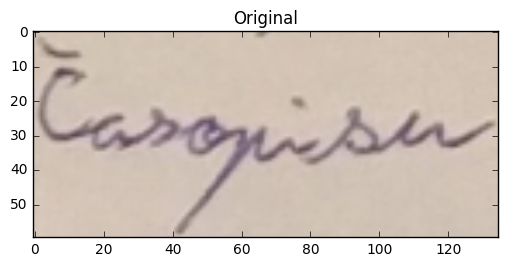

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


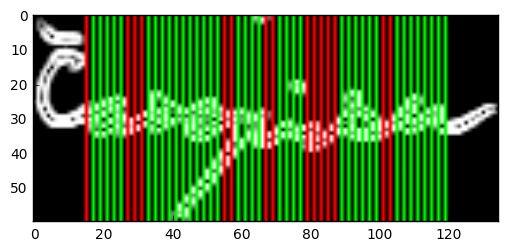

Index: 18


In [15]:
# Class cycling through text positions
# Green - Characters
# Red   - Gaps
LAST_INDEX = 1
cycler = Cycler(crop, bBoxes, LAST_INDEX)

bNexi = widgets.Button(description="Next Image")
    
bNexi.on_click(cycler.nextImg)

display(bNexi)